# Edge Detection Computer Vision

In [1]:
# import libraries
import torch
import cv2
import os
import sys
import time
import random
import torchvision
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
from IPython.display import display
from IPython.display import Image as disp_image

In [2]:
# set global parameters
random.seed(777)
torch.manual_seed(777)
np.seterr(invalid='ignore')
torch.set_printoptions(linewidth=120)
writer = SummaryWriter()

## Data Overview

In [3]:
# base path of the dataset
DATASET_PATH = 'C:/MedicalDATA/BIPED/data/'
PROJECT_PATH = 'C:/BigDataProjects/CV/EdgeDetection/-edge-detection'

In [4]:
# define the path to the images and labels dataset
IMAGE_TRAIN_PATH = DATASET_PATH + 'imgs/train/'
LABEL_TRAIN_PATH = DATASET_PATH + 'labs/train/'

IMAGE_VALID_PATH = DATASET_PATH + 'imgs/test/'
LABEL_VALID_PATH = DATASET_PATH + 'labs/test/'

In [5]:
# display an image sample
img_sample = Image.open(IMAGE_TRAIN_PATH + 'RGB_001.jpg')
print(img_sample)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x180 at 0x1FD02D82880>


In [6]:
# display an label sample
lab_sample = Image.open(LABEL_TRAIN_PATH + 'RGB_001.png')
print(lab_sample)

<PIL.PngImagePlugin.PngImageFile image mode=L size=320x180 at 0x1FD0C6C0EE0>


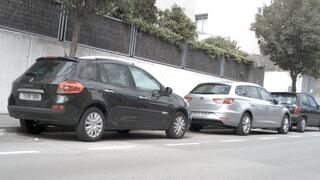

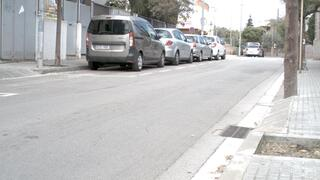

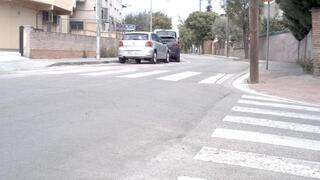

In [7]:
# display images
lst_img_names = [IMAGE_TRAIN_PATH + 'RGB_001.jpg',
                 IMAGE_TRAIN_PATH + 'RGB_002.jpg',
                 IMAGE_TRAIN_PATH + 'RGB_003.jpg']

for img_name in lst_img_names:
    display(disp_image(filename=img_name))

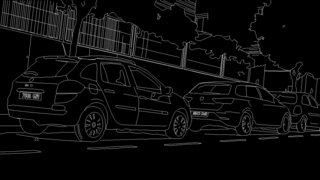

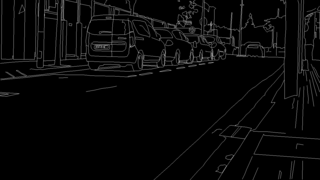

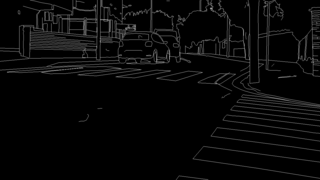

In [8]:
# display labels
lst_lab_names = [LABEL_TRAIN_PATH + 'RGB_001.png',
                 LABEL_TRAIN_PATH + 'RGB_002.png',
                 LABEL_TRAIN_PATH + 'RGB_003.png']

for lab_name in lst_lab_names:
    display(disp_image(filename=lab_name))

## Batch Generation

Data loader `GenerateImageBatch` combines a dataset and a sampler, and provides an iterable over the given dataset. The DataLoader supports both map-style and iterable-style datasets with single- or multi-process loading, customizing loading order and optional automatic batching (collation) and memory pinning.

In [9]:
# Dataloader
disp_image(url='https://blog.kakaocdn.net/dn/b0SVvH/btqLq2FmuEs/1hnCz8VL9wvXPKTOTXzvOk/img.jpg', 
      width=700, height=250)

First of all, main attributes of data are initialized such as height and width of image and labels, their count, their indeces, batch size, input and output. Then, function `next_sample` iterates over images and labels through their indeces and shuffles them. To feed the neural network, function `next_batch` generates input and output data by collecting images and labels into batches using the loop.

In [10]:
# create dataset
class GenerateImageBatch:

    def __init__(self, img, lab, batch_size):

        self.img_h = img.shape[1]
        self.img_w = img.shape[2]
        self.img_count = img.shape[0]
        self.batch_size = batch_size
        self.imgs = img
        self.labs = lab
        self.n = img.shape[0]
        self.indices = list(range(self.n))
        self.cur_index = 0
        self.inputs = None
        self.outputs = None

    # next sample
    def next_sample(self):
        self.cur_index += 1
        
        if self.cur_index >= self.n:
            self.cur_index = 0
            random.shuffle(self.indices)
        
        return self.imgs[self.indices[self.cur_index]], self.labs[self.indices[self.cur_index]]

    # create next batch of images and labels to feed the NN
    def next_batch(self):

        X_data = np.zeros([self.batch_size, self.img_w, self.img_h, 1])
        Y_data = np.zeros([self.batch_size, self.img_w, self.img_h, 1])

        for i in range(self.batch_size):
            img, lab = self.next_sample()
            img = img.T
            img = np.expand_dims(img, -1)
            X_data[i] = img
            lab = lab.T
            lab = np.expand_dims(lab, -1)
            Y_data[i] = lab

        inputs = X_data
        outputs = Y_data
        self.inputs = inputs
        self.outputs = outputs

## Model

### Device

The `torch.device` enables to specify the device type responsible to load a tensor into memory. The function expects a string argument specifying the device type. It is possible to pass an ordinal like the device index. or leave it unspecified for PyTorch to use the currently available device

In [11]:
# device parameters for pytorch model and root directory
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Convolution

Two-dimensional convolution `nn.Conv2d` is applied over a given input where the specific shape of the input images is given in the form of size, length, width, channels, and hence the output must be in a convoluted manner is called PyTorch Conv2d. Conv2d is the function to do any changes in the convolution of two-dimensional data and it mainly pertains to an image in the system where regularizations can be applied too.

A convolution operation is performed on the 2D matrix provided in the system where any operations on a matrix such as matrix inversion or MAC operation is carried out with Conv2d function in the PyTorch module. This belongs to torch.nn package in which all the neural networks functions are available thus managing the tensors and convolutions of matrices. An image is modified and made into two, so the product of these two must help in reporting the value in the output.

Conv2d is added to the layers of the neural network and in PyTorch, it is an instance of the nn module. These layers become the first layers in the network with specific parameters. A number of channels of the input data to be declared in the parameters along with the number of feature maps in the above layer. Instead of a number of channels, the number of feature maps can be used as input which has to be generated in the output. It is simple as it has to import all the required libraries along with the number of strides that must be given in the code. 

The syntax must be like this:
a = Conv2d(in_channels, out_channels, kernel_size=(n, n), stride, padding, bias)

The following parameters are used in PyTorch Conv2d. `in_channels` are used to describe how many channels are present in the input image whereas `out_channels` are used to describe the number of channels present after convolution happened in the system. The breadth and height of the filter is provided by the kernel. The field stride explains the stride of the convolution that happens in the system. The amount of implicit paddings is controlled by the field padding where a number of points are explained in each dimension.

If there is a bias happens in the result and if the user knows it beforehand, it is better to give in the code beforehand using the field bias. The output received from the Conv2d is always a tensor. `Padding_mode` is another field that explains how padding happens in the code and the default value happens to be zero. The dilation field explains the space between kernel elements and the default value is 1. Groups can be used if there are any values blocked from input to output and hence it does not appear in the output.

In [12]:
# 2d convolution
disp_image(url='https://www.sharetechnote.com/image/Python_Pytorch_nn_Conv2D_Overview_01.png', 
      width=700, height=650)

### Gaussian filter

The Gaussian Smoothing Operator `get_gaussian_kernel` performs a weighted average of surrounding pixels based on the Gaussian distribution. It is used to remove Gaussian noise and is a realistic model of defocused lens. Sigma defines the amount of blurring. The radius slider is used to control how large the template is. Large values for sigma will only give large blurring for larger template sizes. The noise can be assumed as edges due to sudden intensity change by the edge detector. The sum of the elements in the Gaussian kernel is 1, so, the kernel should be normalized before applying as convolution to the image. 

In most cases, building a perfect model to capture all the dynamic phenomenon is not possible. To compensate for these unmodeled dynamics, process noise (w) is often added to the dynamic model. Moreover, when measurements are taken, multiple sources of errors, such as calibration errors, are inevitably included in the measurements. To account for these errors, proper measurement noise must be added to the measurement model. An estimation system including these random noises and errors is called a stochastic estimation system, which can be represented by:\
\
$ x _ { k + 1 } = f(x _ { k }, w _ { k }) $ \
$ y _ { k } = h(x _ { k }, v _ { k }) $ \
\
where k is the time step, x<sub>k</sub> is the system state at time step k, f(x<sub>k</sub>) is the state-dependent equation of motion, h(x<sub>k</sub>) is the state dependent measurement equation, and y<sub>k</sub> is the output.

The process noise and measurement noise are assumed to follow zero-mean Gaussian or normal distributions, or are at least be approximated by Gaussian distributions. Also, because the exact state is unknown, the state estimate is a random variable, usually assumed to follow Gaussian distributions. Assuming Gaussian distributions for these variables greatly simplifies the design of an estimation filter, and form the basis of the Kalman filter family.

A Gaussian distribution for a random variable (x) is parametrized by a mean value μ and a covariance matrix P, which is written as x∼N(μ,P). Given a Gaussian distribution, the mean, which is also the most likely value of x, is defined by expectation (E) as:\
\
$ μ = E[x] $ \
\
The mean is also called the first moment of x about the origin. The covariance that describes of the uncertainty of x is defined by expectation (E) as:\
\
$ P = E[(x - μ)(x - μ) ^ T] $ \
\
The covariance is also called the second moment of x about its mean.

If the dimension of x is one, P is only a scalar. In this case, the value of P is usually denoted by σ<sup>2</sup> and called variance. The square root, σ, is called the standard deviation of x. The standard deviation has important physical meaning. The following figure shows the probability density function (which describes the likelihood that x takes a certain value) for a one-dimensional Gaussian distribution with mean equal to μ and standard deviation equal to σ. 

In [13]:
# Gaussian distribution
disp_image(url='https://it.mathworks.com/help/fusion/ug/normal_distribution.png', 
      width=700, height=400)

In [14]:
# Gaussian filtering
disp_image(url='https://www.projectrhea.org/rhea/images/5/5c/Math2.jpg', 
      width=600, height=250)

### Sobel filter

The Sobel operator `get_sobel_kernel` performs a 2-D spatial gradient measurement on an image and so emphasizes regions of high spatial frequency that correspond to edges. Typically it is used to find the approximate absolute gradient magnitude at each point in an input grayscale image. The operator consists of a pair of 3×3 convolution kernels. One kernel is simply the other rotated by 90°.

In [15]:
# Sobel kernals
disp_image(url='https://www.projectrhea.org/rhea/images/thumb/9/91/XY_Kernels.png/1125px-XY_Kernels.png', 
      width=400, height=180)

These kernels are designed to respond maximally to edges running vertically and horizontally relative to the pixel grid, one kernel for each of the two perpendicular orientations. The kernels can be applied separately to the input image, to produce separate measurements of the gradient component in each orientation (call these G<sub>x</sub> and G<sub>y</sub>). These can then be combined together to find the absolute magnitude of the gradient at each point and the orientation of that gradient. The gradient magnitudes (also known as the edge strengths) can then be determined as an Euclidean distance measure by applying the law of Pythagoras. The gradient magnitude is given by:\
\
$ |G| = \sqrt { { G _ { x } } ^ { 2 } + { G _ { y } } ^ { 2 } } $ \
\
This equation is sometimes simplified by applying Manhattan distance measure. Typically, an approximate magnitude is computed using: \
\
$ |G| = |G _ { x }| + |G _ { y }| $ \
\
It is obvious that an image of the gradient magnitudes often indicate the edges quite clearly. However, the edges are typically broad and thus do not indicate exactly where the edges are. To make it possible to determine this, the direction of the edges must be determined and stored. The angle of orientation of the edge (relative to the pixel grid) giving rise to the spatial gradient is given by: \
\
$ Θ = arctan(G _ { y } / G _ { x }) $ \
\
In this case, orientation Θ is taken to mean that the direction of maximum contrast from black to white runs from left to right on the image, and other angles are measured anti-clockwise from this.

The purpose of Non-maximum suppression defined by `set_local_maxima` and `get_local_maxima` is to convert the "blurred" edges in the image of the gradient magnitudes to "sharp" edges. Basically this is done by preserving all local maxima in the gradient image, and deleting everything else. The algorithm is for each pixel in the gradient image:
1. Round the gradient direction Θ to nearest 45◦, corresponding to the use of an 8-connected neighbourhood.
2. Compare the edge strength of the current pixel with the edge strength of the pixel in the positive and negative gradient direction. I.e. if the gradient direction is north (Θ = 90◦), compare with the pixels to the north and south.
3. If the edge strength of the current pixel is largest, preserve the value of the edge strength. If not, suppress (i.e. remove) the value.

In [16]:
# algorithm goes through all the points on the gradient intensity matrix 
# and finds the pixels with the maximum value in the edge directions
disp_image(url='https://cdn-images-1.medium.com/v2/resize:fit:547/1*CWrXNSbe7s4qSFr5vylyvQ.png', 
      width=600, height=300)

The upper left corner red box present on the above image, represents an intensity pixel of the Gradient Intensity matrix being processed. The corresponding edge direction is represented by the orange arrow with an angle of -pi radians (+/-180 degrees).

In [17]:
# focus on the upper left corner red box pixel
disp_image(url='https://cdn-images-1.medium.com/v2/resize:fit:402/1*K-gnZg4_VPk57Xs0XflIrg.png', 
      width=350, height=300)

The edge direction is the orange dotted line (horizontal from left to right). The purpose of the algorithm is to check if the pixels on the same direction are more or less intense than the ones being processed. In the example above, the pixel (i, j) is being processed, and the pixels on the same direction are highlighted in blue (i, j-1) and (i, j+1). If one those two pixels are more intense than the one being processed, then only the more intense one is kept. Pixel (i, j-1) seems to be more intense, because it is white (value of 255). Hence, the intensity value of the current pixel (i, j) is set to 0. If there are no pixels in the edge direction having more intense values, then the value of the current pixel is kept.

In [18]:
# supress non-maximum values
disp_image(url='https://cdn-images-1.medium.com/v2/resize:fit:373/1*QjoPwEgQ6NOynOwxc4847A.png', 
      width=320, height=300)

In this case the direction is the orange dotted diagonal line. Therefore, the most intense pixel in this direction is the pixel (i-1, j+1).

To sum up, each pixel has 2 main criteria (edge direction in radians, and pixel intensity (between 0–255)). Based on these inputs the non-max suppression steps are:

- Create a matrix initialized to 0 of the same size of the original gradient intensity matrix;
- Identify the edge direction based on the angle value from the angle matrix;
- Check if the pixel in the same direction has a higher intensity than the pixel that is currently processed;
- Return the image processed with the non-max suppression algorithm.

### Double threshold

The edge-pixels remaining after the non-maximum suppression step are (still) marked with their strength pixel-by-pixel. Many of these will probably be true edges in the image, but some may be caused by noise or color variations for instance due to rough surfaces. The simplest way to discern between these would be to use a `threshold`, so that only edges stronger that a certain value would be preserved. The Canny edge detection algorithm uses double thresholding. Edge pixels stronger than the high threshold are marked as strong; edge pixels weaker than the low threshold are suppressed and edge pixels between the two thresholds are marked as weak.

In [19]:
# double threshold
disp_image(url='https://jmlb.github.io/images/20180630/img_04.png', 
      width=600, height=280)

Strong edges are interpreted as "certain edges", and can immediately be included in the final
edge image. Weak edges are included if and only if they are connected to strong edges. The logic is of course that noise and other small variations are unlikely to result in a strong edge
(with proper adjustment of the threshold levels). Thus strong edges will (almost) only be due to
true edges in the original image. The weak edges can either be due to true edges or noise/color
variations. The latter type will probably be distributed independently of edges on the entire
image, and thus only a small amount will be located adjacent to strong edges. Weak edges due
to true edges are much more likely to be connected directly to strong edges.

### Edge Tracking by Hysteresis

Due to some edges are more bright than others, the brighter ones can be considered as strong edges but the lighter ones can actually be edges or they can be because of noise. To solve the problem of which edges are really edges and which are not Canny uses the Hysteresis thresholding. In this, two thresholds are set to "High" and "Low". Any edges with intensity greater than "High" are the sure edges. Any edges with intensity less than "Low" are sure to be non-edges. The edges between "High" and "Low" thresholds are classified as edges only if they are connected to a sure edge otherwise discarded.

Function `hysteresis` is the lagging of an effect — a kind of inertia. In the context of thresholding, it means that areas above some low threshold are considered to be above the threshold if they are also connected to areas above a higher, more stringent, threshold. They can thus be seen as continuations of these high-confidence areas.

In [20]:
# hysteresis thresholding
disp_image(url='https://i0.wp.com/theailearner.com/wp-content/uploads/2019/05/Hysteresis-2.png?w=379&ssl=1', 
      width=350, height=250)

Here, "A" and "B" are sure-edges as they are above "High" threshold. Similarly, "D" is a sure non-edge. Both "E" and "C" are weak edges but since "C" is connected to "B" which is a sure edge, "C" is also considered as a strong edge. Using the same logic "E" is discarded. This way we will get only the strong edges in the image.

Based on the threshold results, the hysteresis consists of transforming weak pixels into strong ones, if and only if at least one of the pixels around the one being processed is a strong one, as described below:

In [21]:
# edge tracking
disp_image(url='https://cdn-images-1.medium.com/v2/resize:fit:675/1*jnqS5hbRwAmU-sgK552Mgg.png', 
      width=600, height=200)

In [22]:
# neural network
class Net(nn.Module):

    def __init__(self, batch_size, k_gaussian=3, k_sobel=3, mu=0, sigma=3):
        super(Net, self).__init__()
        self.batch_size = batch_size

        # gaussian filter
        gaussian_2D = self.get_gaussian_kernel(k_gaussian, mu, sigma)
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=1,
            kernel_size=k_gaussian,
            padding=k_gaussian//2,
            padding_mode='replicate',
            bias=False
        )
        
        gaussian_2D = torch.from_numpy(gaussian_2D)
        gaussian_2D.requires_grad = True
        
        with torch.no_grad():
            self.conv1.weight[:] = gaussian_2D

        # sobel filter x direction
        sobel_2D = self.get_sobel_kernel(k_sobel)
        self.conv2 = nn.Conv2d(
            in_channels=1,
            out_channels=1,
            kernel_size=k_sobel,
            padding=k_sobel//2,
            padding_mode='replicate',
            bias=False
        )
        
        sobel_2D = torch.from_numpy(sobel_2D)
        sobel_2D.requires_grad = True
        
        with torch.no_grad():
            self.conv2.weight[:] = sobel_2D

        # sobel filter y direction
        self.conv3 = nn.Conv2d(
            in_channels=1,
            out_channels=1,
            kernel_size=k_sobel,
            padding=k_sobel//2,
            padding_mode='replicate',
            bias=False
        )
        
        with torch.no_grad():
            self.conv3.weight[:] = sobel_2D.T

        # hysteresis custom kernel
        self.conv4 = nn.Conv2d(
            in_channels=1,
            out_channels=1,
            kernel_size=3,
            padding=1,
            padding_mode='replicate',
            bias=False
        ).to(device)
        
        hyst_kernel = np.ones((3, 3)) + 0.25
        hyst_kernel = torch.from_numpy(hyst_kernel).unsqueeze(0).unsqueeze(0)
        hyst_kernel.requires_grad = False
        
        with torch.no_grad():
            self.conv4.weight = nn.Parameter(hyst_kernel)

        # threshold parameters
        self.low_threshold = torch.nn.Parameter(torch.tensor(0.10), requires_grad=True)
        self.high_threshold = torch.nn.Parameter(torch.tensor(0.20), requires_grad=True)

    def get_gaussian_kernel(self, k=3, mu=0, sigma=1, normalize=True):
        
        # compute 1-dimension gaussian
        gaussian_1D = np.linspace(-1, 1, k)
        
        # compute grid distance from center
        x, y = np.meshgrid(gaussian_1D, gaussian_1D)
        distance = (x ** 2 + y ** 2) ** 0.5
        
        # compute 2-dimension gaussian
        gaussian_2D = np.exp(-(distance - mu) ** 2 / (2 * sigma ** 2))
        gaussian_2D = gaussian_2D / (2 * np.pi * sigma ** 2)

        # normalize part (mathematically)
        if normalize:
            gaussian_2D = gaussian_2D / np.sum(gaussian_2D)
        
        return gaussian_2D

    def get_sobel_kernel(self, k=3):
        
        # get range
        range = np.linspace(-(k // 2), k // 2, k)
        
        # compute a grid, the numerator and the axis-distances
        x, y = np.meshgrid(range, range)
        sobel_2D_numerator = x
        sobel_2D_denominator = (x ** 2 + y ** 2)
        sobel_2D_denominator[:, k // 2] = 1  # avoid division by zero
        sobel_2D = sobel_2D_numerator / sobel_2D_denominator
        
        return sobel_2D

    # get the magnitudes shifted left to make a matrix of the points to the right of pts; 
    # similarly, shift left and down to get the points to the top right of pts.
    def set_local_maxima(self, magnitude, pts, w_num, w_denum, row_slices, col_slices, out):
        
        pts = pts.to(device)
        out = out.to(device)
        
        # 1d vectors of pixels (r_0 = [x1, x2...xn])
        r_0, r_1, r_2, r_3 = row_slices
        c_0, c_1, c_2, c_3 = col_slices        
      
        # magnitude of pixel gradients at each point
        m = magnitude[pts]

        # change of pixel magnitude between sobel-x and sobel-y images
        w = w_num[pts] / w_denum[pts]

        # calculate edge strength of the pixel in positive direction 
        c1 = magnitude[:, 0, r_0, c_0][pts[:, 0, r_1, c_1]]
        c2 = magnitude[:, 0, r_2, c_2][pts[:, 0, r_3, c_3]]
        c_plus = c2 * w + c1 * (1 - w) <= m
        c_plus = c_plus.to(device)
        
        # calculate edge strength of the pixel in negative direction
        c1 = magnitude[:, 0, r_1, c_1][pts[:, 0, r_0, c_0]]
        c2 = magnitude[:, 0, r_3, c_3][pts[:, 0, r_2, c_2]]
        c_minus = c2 * w + c1 * (1 - w) <= m
        c_minus = c_minus.to(device)

        # bitwise addition of edge strength of the pixel 
        # in positive and negative gradient direction         
        out[pts] = c_plus & c_minus
        
        return out
    
    # edge thinning by non-maximum suppression
    def get_local_maxima(self, isobel, jsobel, magnitude, eroded_mask):

        # computes absolute value of each element
        abs_isobel = torch.abs(jsobel)
        abs_jsobel = torch.abs(isobel)

        # filter eroded mask by negative values
        eroded_mask = eroded_mask & (magnitude > 0)

        # normals' orientations
        is_horizontal = eroded_mask & (abs_isobel >= abs_jsobel)
        is_vertical = eroded_mask & (abs_isobel <= abs_jsobel)
        is_up = (isobel >= 0)
        is_down = (isobel <= 0)
        is_right = (jsobel >= 0)
        is_left = (jsobel <= 0)
        
        # --------- Find local maxima --------------
        #
        # Assign each point to have a normal of 0-45 degrees, 45-90 degrees,
        # 90-135 degrees and 135-180 degrees.
        #
        local_maxima = torch.zeros(magnitude.shape, dtype=bool)
        
        # ----- 0 to 45 degrees ------
        # mix diagonal and horizontal
        pts_plus = is_up & is_right
        pts_minus = is_down & is_left
        pts = ((pts_plus | pts_minus) & is_horizontal)
        
        # Get the magnitudes shifted left to make a matrix of the points to the
        # right of pts. Similarly, shift left and down to get the points to the
        # top right of pts.
        local_maxima = self.set_local_maxima(
            magnitude, pts, abs_jsobel, abs_isobel,
            [slice(1, None), slice(-1), slice(1, None), slice(-1)],
            [slice(None), slice(None), slice(1, None), slice(-1)],
            local_maxima
        )
        
        # ----- 45 to 90 degrees ------
        # mix diagonal and vertical
        pts = ((pts_plus | pts_minus) & is_vertical)
        local_maxima = self.set_local_maxima(
            magnitude, pts, abs_isobel, abs_jsobel,
            [slice(None), slice(None), slice(1, None), slice(-1)],
            [slice(1, None), slice(-1), slice(1, None), slice(-1)],
            local_maxima
        )
        
        # ----- 90 to 135 degrees ------
        # mix anti-diagonal and vertical
        pts_plus = is_down & is_right
        pts_minus = is_up & is_left
        pts = ((pts_plus | pts_minus) & is_vertical)
        local_maxima = self.set_local_maxima(
            magnitude, pts, abs_isobel, abs_jsobel,
            [slice(None), slice(None), slice(-1), slice(1, None)],
            [slice(1, None), slice(-1), slice(1, None), slice(-1)],
            local_maxima
        )
        
        # ----- 135 to 180 degrees ------
        # mix anti-diagonal and anti-horizontal
        pts = ((pts_plus | pts_minus) & is_horizontal)
        local_maxima = self.set_local_maxima(
            magnitude, pts, abs_jsobel, abs_isobel,
            [slice(-1), slice(1, None), slice(-1), slice(1, None)],
            [slice(None), slice(None), slice(1, None), slice(-1)],
            local_maxima
        )

        return local_maxima

    # thresholds for defining weak and strong edge pixels
    def threshold(self, img):
    
        alpha = 100000
        weak = 0.5
        strong = 1
        
        res_strong = strong * (alpha * (img - self.high_threshold)).sigmoid()
        res_weak_1 = weak * (alpha * (self.high_threshold - img)).sigmoid()
        res_weak_2 = weak * (alpha * (self.low_threshold - img)).sigmoid()
        res_weak = res_weak_1 - res_weak_2
        res = res_weak + res_strong

        return res

    def hysteresis(self, img):

        # create image that has strong pixels remain at one, weak pixels become zero
        img_strong = img.clone()
        img_strong[img == 0.5] = 0

        # create masked image that turns all weak pixel into ones, rest to zeros
        masked_img = img.clone()
        masked_img[torch.logical_not(img == 0.5)] = 0
        masked_img[img == 0.5] = 1

        # calculate weak edges that are changed to strong edges
        changed_edges = img.clone()
        changed_edges[((self.conv4(img_strong) > 1) & (masked_img == 1))] = 1

        # add changed edges to already good edges
        changed_edges[changed_edges != 1] = 0

        return changed_edges

    def forward(self, x):

        # Gaussian filter
        x = self.conv1(x)

        # Sobel filter
        sobel_x = self.conv2(x)
        sobel_y = self.conv3(x)

        # magnitude and angles
        eps = 1e-10
        self.grad_magnitude = torch.hypot(sobel_x + eps, sobel_y + eps)

        # non-max suppression
        eroded_mask = torch.ones((self.batch_size, 1, 320, 180), dtype=bool).to(device)
        eroded_mask[:, 0, :1, :] = 0
        eroded_mask[:, 0, -1:, :] = 0
        eroded_mask[:, 0, :, :1] = 0
        eroded_mask[:, 0, :, -1:] = 0
        thin_edges = self.get_local_maxima(sobel_x, sobel_y, self.grad_magnitude, eroded_mask)
        thin_edges = self.grad_magnitude * (thin_edges * 1)

        # double threshold
        thin_edges = thin_edges / torch.max(thin_edges)
        thresh = self.threshold(thin_edges)

        # hysteresis
        result = self.hysteresis(thresh)
        
        return result

### Training

Neural network training is the process of teaching a neural network to perform a task. Neural networks learn by initially processing several large sets of labeled data. By using the model built, they can then process unknown inputs with regard to loss function.

The Dice score is used to quantify the performance of image segmentation. The algorithm is validated by calculating the Dice score, which is a measure of how similar the objects are. So it is the size of the overlap of the two segmentations divided by the total size of the two objects. Using the same terms as describing accuracy, the Dice score is:

In [23]:
# dice score
disp_image(url='https://www.mdpi.com/electronics/electronics-09-01199/article_deploy/html/images/electronics-09-01199-g0A1-550.jpg', 
      width=700, height=500)

\
$ Dice = { { 2 * TP } \over { (TP + FP) + (TP + FN) } } $ \
\
The number of true positives, is the number that method finds, the number of positives is the total number of positives that can be found and the number of false positives is the number of points that are negative that the method classifies as positive.

The Dice score is not only a measure of how many positives you find, but it also penalizes for the false positives that the method finds, similar to precision, so it is more similar to precision than accuracy. The only difference is the denominator, thete is the total number of positives instead of only the positives that the method finds. So the Dice score is also penalizing for the positives that the algorithm/method could not find.

In the case of image segmentation, there is a mask with ground truth (A). The mask has values 1 in the pixels where there are edges that have to be found and else zero. Likewise, there is an algorithm to generate image/mask (B), which also has to be a binary image, i.e. a mask is created for segmentation. Then there are following statements:

- `Number of positives` is the total number of pixels that have intensity 1 in image A.
- `Number of true positives` is the total number of pixels which have the value 1 in both A and B, so it is the intersection of the regions of ones in A and B. It is the same as using the AND operator on A and B.
- `Number of false positives` is the number of pixels which appear as 1 in B but zero in A.

In [24]:
# calculate algorithm efficiency
def dice_loss(input, target):
    smooth = 1.
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()

    return (1 - ((2. * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth)))

In [25]:
# convert all images in a directory to '.npy' format.
def load_dataset(path, data):
    
    # path to image directory
    dirs = os.listdir(path)
    dirs.sort()    
    lst = []
    
    # append images to a list
    for item in dirs:
        
        # flag images
        if data == 'img':
            if os.path.isfile(path + item):
                im = Image.open(path + item).convert('L')
                im = np.array(im)
                lst.append(im)

        # flag labels
        if data == 'lab':
            if os.path.isfile(path + item):
                im = Image.open(path + item)
                im = np.array(im)
                lst.append(im)

    return lst            

In [26]:
# load training images and labels into arrays
train_img = load_dataset(path=IMAGE_TRAIN_PATH, data='img')
train_lab = load_dataset(path=LABEL_TRAIN_PATH, data='lab')

# load validation images and labels into arrays
valid_img = load_dataset(path=IMAGE_VALID_PATH, data='img')
valid_lab = load_dataset(path=LABEL_VALID_PATH, data='lab')

In [27]:
# convert and save the list of images and labels in '.npy' format
train_img_arr = np.array(train_img)
np.save(DATASET_PATH + 'train_image.npy', train_img_arr)

train_lab_arr = np.array(train_lab)
np.save(DATASET_PATH + 'train_label.npy', train_lab_arr)

valid_img_arr = np.array(valid_img)
np.save(DATASET_PATH + 'valid_image.npy', valid_img_arr)

valid_lab_arr = np.array(valid_lab)
np.save(DATASET_PATH + 'valid_label.npy', valid_lab_arr)

The whole cycle of machine learning process includes forward and backward passes. The "forward pass" refers to calculation process, values of the output layers from the inputs data. It's traversing through all neurons from first to last layer. A loss function (Dice score) is calculated from the output values.

And then "backward pass" refers to process of counting changes in weights (de facto learning), using gradient descent algorithm. Computation is made from last layer, backward to the first layer.

Backward and forward pass makes together one "iteration".

During one iteration, a subset of the data set is passed (batch). Every "Epoch" the entire data set is passing in batches. One epoch contains (number_of_items / batch_size) iterations.

In [28]:
# training and validation of the model
def main():

    # load data
    train_images = np.load(DATASET_PATH + 'train_image.npy')
    train_labels = np.load(DATASET_PATH + 'train_label.npy')

    valid_images = np.load(DATASET_PATH + 'valid_image.npy')
    valid_labels = np.load(DATASET_PATH + 'valid_label.npy')

    # create batch architecture
    batch_size = 1
    epochs = 3
    learning_rate = 0.01 
    train_data = GenerateImageBatch(train_images, train_labels, batch_size)
    valid_data = GenerateImageBatch(valid_images, valid_labels, batch_size)

    # create model object
    net = Net(batch_size)
    net.to(device)

    # convert to float
    net = net.float()

    # set up the optimizer, the loss, the learning rate scheduler 
    # and the loss scaling for AMP
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    criterion = dice_loss

    # begin training
    for epoch in range(1, epochs+1):
        
        net.train()
        train_loss = 0
        
        for i in range(int(train_data.img_count / batch_size)):
            
            # forward pass: compute predicted 'y' by passing 'x' to the model
            train_data.next_batch()

            inputs = train_data.inputs
            inputs.astype(np.float32)
            inputs = np.transpose(inputs, (0, 3, 1, 2))
            inputs = torch.from_numpy(inputs)

            outputs = torch.from_numpy(train_data.outputs.astype(np.float32))
            outputs = np.transpose(outputs.float(), (0, 3, 1, 2))

            inputs, outputs = inputs.to(device), outputs.to(device)
            
            inputs = inputs.type(torch.float32)
            outputs = outputs.type(torch.float32)

            y_pred = net(inputs)
            y_pred = y_pred.to(device)

            # compute and print loss
            loss = criterion(y_pred, outputs)

            writer.add_scalar('Loss/train', loss, epoch)
            print('Loss:')
            print(loss)

            # zero gradients, perform a backward pass, and update the weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # calculate Loss
            train_loss += loss.item()

        net.eval()
        valid_loss = 0
        
        with torch.no_grad():
            for i in range(int(valid_data.img_count / batch_size)):
                
                valid_data.next_batch()
                
                inputs = valid_data.inputs
                inputs = np.transpose(inputs, (0, 3, 1, 2))
                inputs.astype(np.float32)
                inputs = torch.from_numpy(inputs)

                outputs = torch.from_numpy(valid_data.outputs)
                outputs = np.transpose(outputs, (0, 3, 1, 2))

                inputs, outputs = inputs.to(device), outputs.to(device)
                
                inputs = inputs.type(torch.float32)
                outputs = outputs.type(torch.float32)

                y_pred = net(inputs)

                # compute and print loss
                loss = criterion(y_pred, outputs)

                writer.add_scalar('Loss/validate', loss, epoch)
                valid_loss += loss.item()

        t_loss = train_loss / (int(train_data.img_count / batch_size))
        v_loss = valid_loss / (int(valid_data.img_count / batch_size))

        print(f'Epoch {epoch} \t\t Train Loss: {t_loss} \t\t Valid Loss: {v_loss}')
        print(f'Validation Loss {valid_loss:.6f}) \t Saving The Model')
        
        # save 'state dict'
        train = train_loss / (int(train_data.img_count / batch_size))
        valid = valid_loss / (int(valid_data.img_count / batch_size))
        
        string = str(epoch) + '_train-loss_' + str(train) + '_val_loss_' + str(valid) + '.pth'
        torch.save(net.state_dict(), PROJECT_PATH + '/train_results/epoch_' + string)

    writer.flush()
    writer.close()


if __name__ == '__main__':
    main()

Loss:
tensor(0.4309, grad_fn=<RsubBackward1>)
Loss:
tensor(0.4358, grad_fn=<RsubBackward1>)
Loss:
tensor(0.5842, grad_fn=<RsubBackward1>)
Loss:
tensor(0.4180, grad_fn=<RsubBackward1>)
Loss:
tensor(0.0820, grad_fn=<RsubBackward1>)
Loss:
tensor(0.3665, grad_fn=<RsubBackward1>)
Loss:
tensor(0.5074, grad_fn=<RsubBackward1>)
Loss:
tensor(0.3979, grad_fn=<RsubBackward1>)
Loss:
tensor(0.5193, grad_fn=<RsubBackward1>)
Loss:
tensor(0.6123, grad_fn=<RsubBackward1>)
Loss:
tensor(0.5524, grad_fn=<RsubBackward1>)
Loss:
tensor(0.4700, grad_fn=<RsubBackward1>)
Loss:
tensor(0.4871, grad_fn=<RsubBackward1>)
Loss:
tensor(0.7393, grad_fn=<RsubBackward1>)
Loss:
tensor(0.5305, grad_fn=<RsubBackward1>)
Loss:
tensor(0.5230, grad_fn=<RsubBackward1>)
Loss:
tensor(0.4857, grad_fn=<RsubBackward1>)
Loss:
tensor(0.4937, grad_fn=<RsubBackward1>)
Loss:
tensor(0.7410, grad_fn=<RsubBackward1>)
Loss:
tensor(0.6929, grad_fn=<RsubBackward1>)
Loss:
tensor(0.6372, grad_fn=<RsubBackward1>)
Loss:
tensor(0.5214, grad_fn=<Rsub